@author ArturoSirvent


In [11]:
from fbpinns import domains, problems, decompositions, networks, constants, trainers
import fbpinns
import numpy as np

from fbpinns.domains import RectangularDomainND
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN
from fbpinns.constants import Constants
from fbpinns.trainers import FBPINNTrainer

In [13]:
a=RectangularDomainND


In [16]:
a.init_params(xmin=np.array([0,0,0]),xmax=np.array([1,1,1]))

({'xd': 3,
  'xmin': Array([0, 0, 0], dtype=int32),
  'xmax': Array([1, 1, 1], dtype=int32)},
 {})

In [9]:
c = Constants(
    domain=RectangularDomainND,# use a 1D problem domain [0, 1]
    domain_init_kwargs=dict(
        xmin=np.array([0,]),
        xmax=np.array([1,]),
    ),
    problem=HarmonicOscillator1DHardBC,
    problem_init_kwargs=dict(
        d=2, w0=80,# define the ODE parameters
    ),
    decomposition=RectangularDecompositionND,# use a rectangular domain decomposition
    decomposition_init_kwargs=dict(
        subdomain_xs=[np.linspace(0,1,15)],# use 15 equally spaced subdomains
        subdomain_ws=[0.15*np.ones((15,))],# with widths of 0.15
        unnorm=(0.,1.),# define unnormalisation of the subdomain networks
    ),
    network=FCN,# place a fully-connected network in each subdomain
    network_init_kwargs=dict(
        layer_sizes=[1,32,1],# with 2 hidden layers
    ),
    ns=((200,),),# use 200 collocation points for training
    n_test=(500,),# use 500 points for testing
    n_steps=20000,# number of training steps
    clear_output=True,
)

TypeError: RectangularDomainND() takes no arguments

In [ ]:

# Definir un dominio 3D.
domain = domains.BoxDomain(xmin=0, xmax=1, ymin=0, ymax=1, zmin=0, zmax=1)  # Ajusta los límites según tus necesidades

# Definir las ecuaciones de elasticidad lineal y las condiciones de frontera.
def pde(u, x, y, z):
    # Aquí debes definir las ecuaciones diferenciales
    pass

def boundary_condition(u, x, y, z):
    # Aquí debes definir las condiciones de frontera
    pass

problem = problems.CustomProblem(domain=domain, pde=pde, boundary_condition=boundary_condition)

# Definir la descomposición del dominio.
decomposition = decompositions.UniformDecomposition(domain=domain, num_subdomains=... )  # Define el número de subdominios

# Seleccionar o definir una red neuronal.
network = networks.FullyConnectedNetwork(layers=..., activation_function=...)  # Define las capas y la función de activación

# Configuración de entrenamiento
constants = constants.Constants(learning_rate=..., epochs=...)  # Define la tasa de aprendizaje y el número de épocas

# Entrenar la red
trainer = trainers.FBPINNTrainer(problem=problem, decomposition=decomposition, network=network, constants=constants)
trainer.train()


(3, 1)
(4, 1)


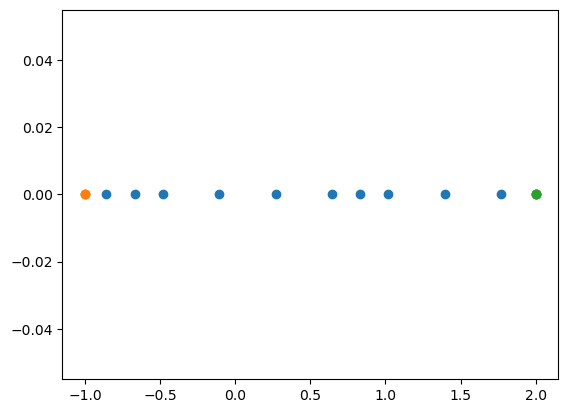

(3, 2)
(4, 2)
(5, 2)
(6, 2)


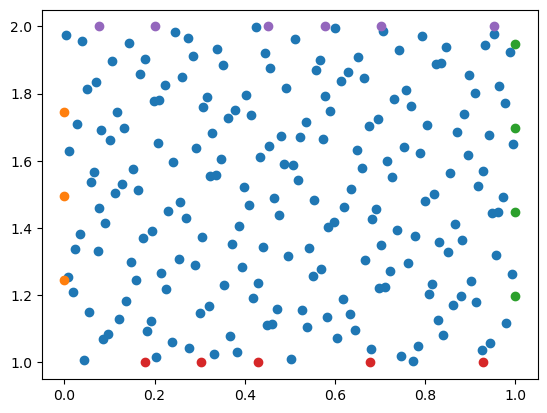

In [17]:
"""
Defines problem domains

Each domain class must inherit from the Domain base class.
Each domain class must define the NotImplemented methods.

This module is used by constants.py (and subsequently trainers.py)
"""

import jax
import jax.numpy as jnp
import numpy as np
import scipy.stats

from fbpinns import networks


class Domain:
    """Base domain class to be inherited by different domain classes.

    Note all methods in this class are jit compiled / used by JAX,
    so they must not include any side-effects!
    (A side-effect is any effect of a function that doesn’t appear in its output)
    This is why only static methods are defined.
    """

    # required methods

    @staticmethod
    def init_params(*args):
        """Initialise class parameters.
        Returns tuple of dicts ({k: pytree}, {k: pytree}) containing static and trainable parameters"""

        # below parameters need to be defined
        static_params = {
            "xd":None,# dimensionality of x
            }
        raise NotImplementedError

    @staticmethod
    def sample_interior(all_params, key, sampler, batch_shape):
        """Samples interior of domain.
        Returns x_batch points in interior of domain"""
        raise NotImplementedError

    @staticmethod
    def sample_boundaries(all_params, key, sampler, batch_shapes):
        """Samples boundaries of domain.
        Returns (x_batch, ...) tuple of points for each boundary"""
        raise NotImplementedError

    @staticmethod
    def norm_fn(all_params, x):
        """"Applies norm function, for a SINGLE point with shape (xd,)"""# note only used for PINNs, FBPINN norm function defined in Decomposition
        raise NotImplementedError




class RectangularDomainND(Domain):

    @staticmethod
    def init_params(xmin, xmax):

        assert xmin.shape == xmax.shape
        assert xmin.ndim == 1
        xd = len(xmin)

        static_params = {
            "xd":xd,
            "xmin":jnp.array(xmin),
            "xmax":jnp.array(xmax),
            }
        return static_params, {}

    @staticmethod
    def sample_interior(all_params, key, sampler, batch_shape):
        xmin, xmax = all_params["static"]["domain"]["xmin"], all_params["static"]["domain"]["xmax"]
        return RectangularDomainND._rectangle_samplerND(key, sampler, xmin, xmax, batch_shape)

    @staticmethod
    def sample_boundaries(all_params, key, sampler, batch_shapes):
        xmin, xmax = all_params["static"]["domain"]["xmin"], all_params["static"]["domain"]["xmax"]
        xd = all_params["static"]["domain"]["xd"]

        assert len(batch_shapes) == 2*xd# total number of boundaries

        x_batches = []
        for i in range(xd):
            ic = jnp.array(list(range(i))+list(range(i+1,xd)), dtype=int)
            for j,v in enumerate([xmin[i], xmax[i]]):
                batch_shape = batch_shapes[2*i+j]
                if len(ic):
                    xmin_, xmax_ = xmin[ic], xmax[ic]
                    key, subkey = jax.random.split(key)
                    x_batch_ = RectangularDomainND._rectangle_samplerND(subkey, sampler, xmin_, xmax_, batch_shape)# (n, xd-1)
                    x_batch = v*jnp.ones((jnp.prod(jnp.array(batch_shape)),xd), dtype=float)
                    x_batch = x_batch.at[:,ic].set(x_batch_)
                else:
                    assert len(batch_shape) == 1
                    x_batch = v*jnp.ones(batch_shape+(1,), dtype=float)
                x_batches.append(x_batch)
        return x_batches

    @staticmethod
    def norm_fn(all_params, x):
        xmin, xmax = all_params["static"]["domain"]["xmin"], all_params["static"]["domain"]["xmax"]
        mu, sd = (xmax+xmin)/2, (xmax-xmin)/2
        x = networks.norm(mu, sd, x)
        return x

    @staticmethod
    def _rectangle_samplerND(key, sampler, xmin, xmax, batch_shape):
        "Get flattened samples of x in a rectangle, either on mesh or random"

        assert xmin.shape == xmax.shape
        assert xmin.ndim == 1
        xd = len(xmin)
        assert len(batch_shape) == xd

        if not sampler in ["grid", "uniform", "sobol", "halton"]:
            raise ValueError("ERROR: unexpected sampler")

        if sampler == "grid":
            xs = [jnp.linspace(xmin, xmax, b) for xmin,xmax,b in zip(xmin, xmax, batch_shape)]
            xx = jnp.stack(jnp.meshgrid(*xs, indexing="ij"), -1)# (batch_shape, xd)
            x_batch = xx.reshape((-1, xd))
        else:
            if sampler == "halton":
                # use scipy as not implemented in jax (!)
                r = scipy.stats.qmc.Halton(xd)
                s = r.random(np.prod(batch_shape))
            elif sampler == "sobol":
                r = scipy.stats.qmc.Sobol(xd)
                s = r.random(np.prod(batch_shape))
            elif sampler == "uniform":
                s = jax.random.uniform(key, (np.prod(batch_shape), xd))

            xmin, xmax = xmin.reshape((1,-1)), xmax.reshape((1,-1))
            x_batch = xmin + (xmax - xmin)*s

        return jnp.array(x_batch)



if __name__ == "__main__":

    import matplotlib.pyplot as plt

    key = jax.random.PRNGKey(0)


    domain = RectangularDomainND
    sampler = "halton"


    # 1D

    xmin, xmax = jnp.array([-1,]), jnp.array([2,])
    batch_shape = (10,)
    batch_shapes = ((3,),(4,))

    ps_ = domain.init_params(xmin, xmax)
    all_params = {"static":{"domain":ps_[0]}, "trainable":{"domain":ps_[1]}}
    x_batch = domain.sample_interior(all_params, key, sampler, batch_shape)
    x_batches = domain.sample_boundaries(all_params, key, sampler, batch_shapes)

    plt.figure()
    plt.scatter(x_batch, jnp.zeros_like(x_batch))
    for x_batch in x_batches:
        print(x_batch.shape)
        plt.scatter(x_batch, jnp.zeros_like(x_batch))
    plt.show()


    # 2D

    xmin, xmax = jnp.array([0,1]), jnp.array([1,2])
    batch_shape = (10,20)
    batch_shapes = ((3,),(4,),(5,),(6,))

    ps_ = domain.init_params(xmin, xmax)
    all_params = {"static":{"domain":ps_[0]}, "trainable":{"domain":ps_[1]}}
    x_batch = domain.sample_interior(all_params, key, sampler, batch_shape)
    x_batches = domain.sample_boundaries(all_params, key, sampler, batch_shapes)

    plt.figure()
    plt.scatter(x_batch[:,0], x_batch[:,1])
    for x_batch in x_batches:
        print(x_batch.shape)
        plt.scatter(x_batch[:,0], x_batch[:,1])
    plt.show()





In [27]:
import matplotlib.pyplot as plt

key = jax.random.PRNGKey(0)


domain = RectangularDomainND
sampler = "halton"

# 3D

xmin, xmax = jnp.array([0,1,0]), jnp.array([1,2,1])
batch_shape = (10,20,10)
batch_shapes = ((3,),(4,),(5,),(6,),(3,),(4,))

ps_ = domain.init_params(xmin, xmax)




In [28]:
all_params = {"static":{"domain":ps_[0]}, "trainable":{"domain":ps_[1]}}
x_batch = domain.sample_interior(all_params, key, sampler, batch_shape)
x_batches = domain.sample_boundaries(all_params, key, sampler, batch_shapes)


AssertionError: 

In [26]:

plt.figure()
plt.scatter(x_batch[:,0], x_batch[:,1])
for x_batch in x_batches:
    print(x_batch.shape)
    plt.scatter(x_batch[:,0], x_batch[:,1])
plt.show()


AssertionError: 